# Interpoleerimine

<div style="float: left;">Valter Kiisk<br><span style="font-size: 75%;">TÜ Füüsika Instituut</span></div><div style="float: right;">Viimati muudetud: 16.02.2018</div>
<div style="display:none">
$\renewcommand{\vec}{\boldsymbol}$
$\newcommand{\erf}{\mathop{\rm erf}\nolimits}$
$\newcommand{\mod}{\mathop{\rm mod}\nolimits}$
</div>

In [1]:
import numpy as np
from numpy import linspace, arange, exp, sin, cos, log, sqrt, pi, polyval
from matplotlib.pyplot import *
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['lines.markeredgewidth'] = 0
rcParams['lines.markersize'] = 5
rcParams['font.size'] = 12
rcParams['axes.prop_cycle'] = cycler('color', 'bgrmc')

def axtext(x, y, s, **kwargs):
    annotate(s, (x, y), xycoords='axes fraction',
             backgroundcolor='white', fontsize='small', **kwargs)

## Sissejuhatus

Kuna mistahes eksperimentaalne sõltuvus võetakse paratamatult üles lõpliku sammuga, võib tekkida vajadus mõõdetava suuruse väärtuse hindamiseks ka katsepunktide vahel. Sama probleem on juhul kui tuleb andmetöötluses kasutada olemasolevaid, tabuleeritud andmeid (artiklist, käsiraamatust, vms). Näiteks katsepunktid järgmisel graafikul kirjeldavad kahte sõltuvust, mis oleks tarvis omavahel korrutada (või jagada), aga punktid "pole kohakuti". Siin sõltumatu muutuja rollis võib olla aeg, pinge, lainepikkus vms, mida süstemaatiliselt muudetakse mõõtmise vältel.

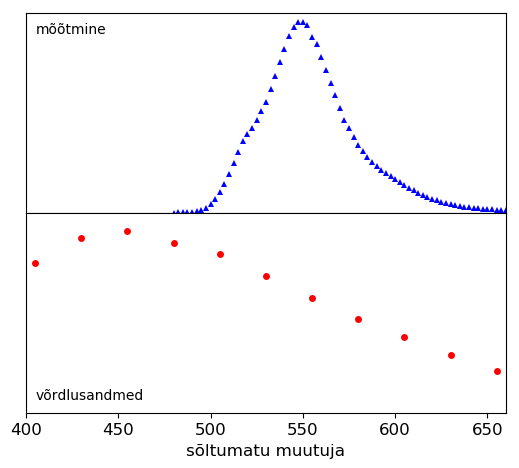

In [2]:
toores = np.loadtxt('toores.txt', unpack=True)
kalib  = np.loadtxt('kalib.txt', unpack=True)

figure(figsize=(6,5))
ax = axes([0.15, 0.5, 0.80, 0.40])  # left, bottom, width, height
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plot(toores[0], toores[1], 'b^')
ylim(ymin=0)
axtext(0.02, 0.95, 'mõõtmine', va='top')
axes([0.15, 0.1, 0.80, 0.40], sharex=ax)
gca().get_yaxis().set_visible(False)
plot(kalib[0], kalib[1], 'ro')
xlabel('sõltumatu muutuja')
xlim(400, 660)
ylim(0, 1.1)
axtext(0.02, 0.05, 'võrdlusandmed', va='bottom')
show()

Põhimõtteliselt on valida selliste variantide vahel:

* Kui andmeseeriat kirjeldav teoreetiline sõltuvus on teada ja piisavalt lihtne, saab kasutada [funktsiooni sobitamist](fit.html) vähimruutude meetodil.
* Kui katseandmed on suure määramatusega ehk "mürased", võib leppida mõne parajalt paindliku matemaatilise sõltuvusega, millel teoreetilist põhjendust ei pruugi olla (näiteks polünoom). Põhimõtteliselt tähendab see andmete silumist.
* Kui katsepunktide määramatus on piisavalt väike, on õigustatud *interpoleerimine*, st konstrueeritakse võimalikult sile kõver, mis läbib täpselt kõiki katsepunkte.

## Interpolatsioonipolünoom

Kui andmepunktide arv $n$ on võrdlemisi väike (suurusjärgus mõnikümmend või vähem), andmed on täpsed ja sõltuvus ei ole väga iseäraliku kujuga, on mõeldav sobitada läbi nende punktide üksainus piisavalt kõrget järku polünoom. Selle järk tuleb ilmselt $n-1$ (näiteks läbi kolme punkti saab ajada parabooli).

Leiame näitena sellise parabooli $y=ax^2+bx+c$, mis läheb täpselt läbi punktide $(x_1=1,y_1=10)$, $(x_2=2,y_2=5)$ ja $(x_3=4,y_3=13)$. Niisiis tuleb lahendada lineaarne võrrandisüsteem $$\begin{cases}a(x_1)^2+bx_1+c=y_1\\ a(x_2)^2+bx_2+c=y_2\\ a(x_3)^2+bx_3+c=y_3\end{cases}$$ kus võrrandeid on täpselt sama palju kui tundmatuid ($a,b,c$). Selle võrrandisüsteemi kordajate maatriks on $$M=\begin{bmatrix} (x_1)^2 & x_1 & 1\\ (x_2)^2 & x_2 & 1\\(x_3)^2 & x_3 & 1\end{bmatrix}.$$ Seesuguse spetsiifilise struktuuriga nn [Vandermonde'i maatriksi](https://en.wikipedia.org/wiki/Vandermonde_matrix) saab konstrueerida käsuga `numpy.vander` ja lineaarvõrrandisüsteemi lahendi annab `numpy.linalg.solve`.

a = 3.0
b = -14.0
c = 21.0


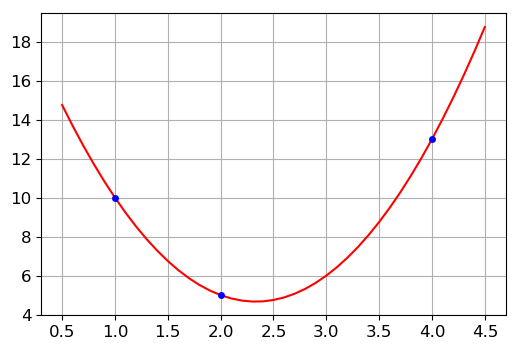

In [3]:
# katsepunktid
X = np.array((1, 2, 4), dtype=np.float)
Y = np.array((10, 5, 13), dtype=np.float)

# võrrandisüsteemi lahend
M = np.vander(X, 3)
P = np.linalg.solve(M, Y)
for k,p in zip('abc', P):
    print('%s = %.1f' % (k, p))

X1 = arange(0.5, 4.6, 0.1)  # interpoleeritud kõvera jaoks punkte tihedamalt
Y1 = polyval(P, X1)
plot(X1, Y1, 'r-')
plot(X, Y, 'bo')
grid()
show()

Selline $n-1$ järku polünoom (läbi $n$ punkti) on ühene ja selle saab ilmutatult konstrueerida mitmel erineval kujul. Näiteks *Lagrange'i interpolatsioonivalem*: $$f(x)=\sum_i y_i L_i(x),\quad\text{kus}\quad L_i(x)=\prod_{j\neq i}\frac{x-x_j}{x_i-x_j}.$$

Veidi efektiivsema ja numbriliselt stabiilsema algoritmi realiseerib `scipy.interpolate.BarycentricInterpolator`:

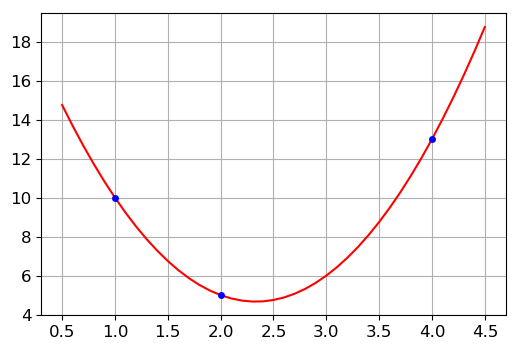

In [4]:
from scipy.interpolate import BarycentricInterpolator

interp = BarycentricInterpolator(X, Y)
Y1 = interp(X1)

plot(X1, Y1, 'r-')
plot(X, Y, 'bo')
grid()
show()

Oluliselt suurema arvu katsepunktide korral, mis järgivad mingit põhimõtteliselt mitte-polünomiaalset sõltuvust, ei pruugi tulemus olla enam nii kena:

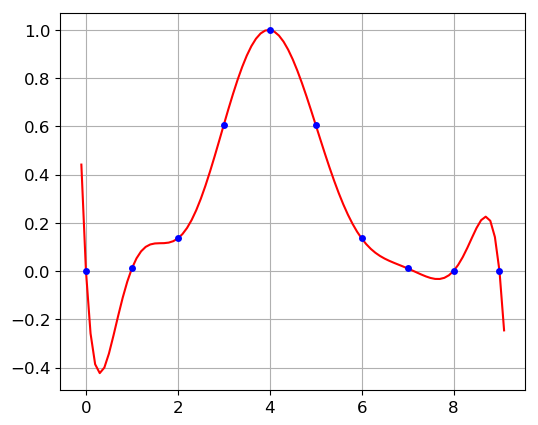

In [5]:
n = 10 # katsepunktide arv
X = linspace(0, 9, n)
Y = exp(-0.5*(X-4)**2)

interp = BarycentricInterpolator(X, Y)
X1 = arange(-0.1, 9.2, 0.1)
Y1 = interp(X1)

figure(figsize=(6,5))
plot(X1, Y1, 'r-')
plot(X, Y, 'bo')
grid()
show()

Kuigi siin katsepunktid on võrdlemisi regulaarsed, on juba näha [Runge fenomen](https://en.wikipedia.org/wiki/Runge%27s_phenomenon), st kõrget järku interpolatsioonipolünoom peaaegu piiramatult hälbib tegelikust sõltuvusest (mis antud juhul on Gaussi kelluke). Selle kõige tõttu on interpolatsioonipolünoomi praktiline väärtus väike. Pigem on mõistlik kasutada *tükati polünomiaalset* interpoleerimist.

## Lineaarne interpolatsioon

Kõige soodsam olukord interpoleerimiseks on juhul, kui katsepunktid paiknevad väga tihedalt või on muutused väga aeglased. Sel juhul on õigustatud *lineaarne interpolatsioon*, st katsepunktid ühendatakse sirgjoonega. NumPy võimaldab lineaarset interpolatsiooni teostada funktsiooniga `numpy.interp`:

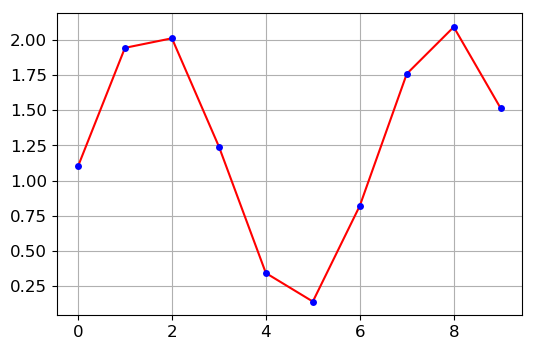

In [6]:
n = 10
X = linspace(0, 9, n)
Y = sin(X) + 1.1
X1 = linspace(0, 9, 100)
Y1 = np.interp(X1, X, Y)
plot(X1, Y1, 'r-')
plot(X, Y, 'bo')
grid()
show()

Kõrvalepõikena mainime, et sellist tükati pidevat interpoleerimist teostavad algoritmid reeglina eeldavad, et andmed on sorditud x-väärtuse järgi kasvavasse järjestusse. Kui mingil põhjusel on algandmed kahanevas järjestuses, siis mõlemad andmevektorid tuleb lihtsalt ringi pöörata meetodiga `reverse()`, mis on olemas nii Pythoni järjenditel kui ka `numpy` massiividel. Sortimine on praktiliselt sama lihtne. Hetkel meil on andmevektorid `X` ja `Y` juba sorteeritud, seega sortimise demonstreerimiseks tuleks esmalt katsepunktide järjestus muuta juhuslikuks (nagu kaardipaki segamisel). Seda saavutame funktsiooniga `numpy.random.shuffle`, mida rakendame mitte andmevektorile `X`, vaid indeksite vektorile `numpy.arange(N)`. Seejärel saab üht ja sama juhuslikku indeksite järjestust rakendada nii massiivile `X` kui ka `Y`, nii et säilib vastavus x- ja y-väärtuste vahel.

In [7]:
I = np.arange(n)
np.random.shuffle(I)
X, Y = X[I], Y[I]
for x,y in zip(X,Y):
    print( '%4.1f %5.2f' % (x,y) )

 4.0  0.34
 0.0  1.10
 3.0  1.24
 2.0  2.01
 6.0  0.82
 8.0  2.09
 7.0  1.76
 5.0  0.14
 1.0  1.94
 9.0  1.51


Nüüd sortimiseks rakendame massiivile `X` funktsiooni `numpy.argsort`. Viimane mitte ei sordi massiivi, vaid tagastab sorditud massiivi indeksite vektori. Viimase abil saame jällegi mõlemad andmevektorid sünkroniseeritult sortida.

In [8]:
I = np.argsort(X)
X, Y = X[I], Y[I]
for x,y in zip(X,Y):
    print( '%4.1f %5.2f' % (x,y) )

 0.0  1.10
 1.0  1.94
 2.0  2.01
 3.0  1.24
 4.0  0.34
 5.0  0.14
 6.0  0.82
 7.0  1.76
 8.0  2.09
 9.0  1.51


Funktsioonile `numpy.argsort` saaks parameetrina `kind` anda ka sortimisalgoritmi nime (sortimisalgoritme on olemas mitmeid), aga nii vähese hulga andmete korral ei ole sellel tähtsust. Vaikimisi kasutatakse [kiirsortimist](https://en.wikipedia.org/wiki/Quicksort)  (`quicksort`).

## Kuupsplain

Lineaarse interpoleerimise algoritm on küll väga lihtne, aga vaadeldavas näites see ei anna eriti loomulikku tulemust, sest andmepunktid paiknevad üsna hõredalt. Pigem võiks katsepunktid ühendada sirge asemel veidi kõrgemat järku polünoomiga (sirge on $1$-järku polünoom). Sel juhul tekib hulk vabu parameetreid, nii et saab need polünoomid sõlmpunktides võimalikult siledalt kokku siduda. Sellist interpolatsiooni nimetatakse [splainiks](https://en.wikipedia.org/wiki/Spline_%28mathematics%29).  Näiteks *kuupsplain* koosneb tükati kuuppolünoomidest, nii et sõlmpunktides on esimene ja teine tuletis pidevad.

Olgu meil $n$ andmepunkti. Iga kahe punkti vahel on splain kirjeldatud kuuppolünoomiga $$S_i(x)=a_i+b_i(x-x_i)+c_i(x-x_i)^2+d_i(x-x_i)^3.$$ Vahemikke on kokku $n-1$ tükki ja vabasid parameetreid seega $4(n-1)$. Püüame saada kokku sama suure hulga võrrandeid:

* Splain peab läbima vahemiku kumbagi otspunkti: $S_i(x_i)=y_i$ ja $S_i(x_{i+1})=y_{i+1}$. See annab kokku $2(n-1)$ seost. Veel samapalju vabu parameetreid jääb järgi.
* Vahesõlmedes $S_i'(x_{i+1})=S_{i+1}'(x_{i+1})$ ja $S_i''(x_{i+1})=S_{i+1}''(x_{i+1})$. See annab kokku $2(n-2)$ seost, järgi jääb veel vaid 2 vaba parameetrit.
* Otspunktides tuleb splainide kuju fikseerida võimalikult "loomulikul" viisil, näiteks $S_i''(x_1)=0$ ja $S_{n-1}''(x_n)=0$. Teise tuletise fikseerimine ei piira kõvera tõusu (st 1. tuletise väärtust).

Splain ise ja selle tuletised on lineaarsed funktsioonid $a_i,b_i,c_i,d_i$ suhtes, nii et kirjeldatud protseduuriga saame lineaarvõrrandisüsteemi, mille lahendamine on sirgjooneline.

Nii lineaarset kui ka erinevat järku splainidega interpoleerimist võimaldab `scipy.interpolate.interp1d`. Kasutame samu lähteandmeid lineaarse ja kuupsplaini võrdlemiseks:

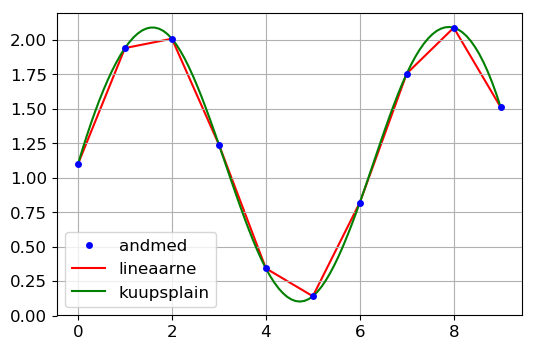

In [9]:
from scipy.interpolate import interp1d
f1 = interp1d(X, Y) # vaikimisi lineaarne interpolatsioon
f2 = interp1d(X, Y, kind='cubic')
plot(X, Y, 'bo', label='andmed', zorder=3)
plot(X1, f1(X1), 'r-', label='lineaarne', zorder=1)
plot(X1, f2(X1), 'g-', label='kuupsplain', zorder=2)
legend()
grid()
show()